In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import csv

def find_dicom_images_in_folder(folder_path,folder_path2):
    image_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths.append([os.path.join(root, file), os.path.basename(root)])
    i=0
    for root, dirs, files in os.walk(folder_path2):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths[i].append(os.path.join(root, file))
                i+=1
    return image_paths

def save_paths_to_csv(dicom_paths, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Image_Path","Label", "Mask_Path"])
        for path,path2, label in dicom_paths:
            writer.writerow([path,path2, label])

folder_path = "/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/term2 (1)/7_data_png"
mask_path="/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/term2 (1)/7_mask_data_png"
dicom_paths = find_dicom_images_in_folder(folder_path,mask_path)
if dicom_paths:
    csv_filename ="data_kayıt.csv"
    save_paths_to_csv(dicom_paths, csv_filename)
    print(f"{len(dicom_paths)} DICOM dosyası CSV dosyasına kaydedildi.")
else:
    print("Belirtilen klasörde DICOM dosyası bulunamadı.")



1488 DICOM dosyası CSV dosyasına kaydedildi.


In [3]:
import pandas as pd
df=pd.read_csv("data_kayıt.csv")
df.head()

,Image_Path,Label,Mask_Path
0,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
1,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
2,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
3,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...
4,/content/drive/MyDrive/Colab Notebooks/Pulmona...,ground_glass,/content/drive/MyDrive/Colab Notebooks/Pulmona...


In [ ]:
df.Label.value_counts()

ground_glass     390
fibrosis         386
micronodules     274
consolidation    183
healthy          100
reticulation      89
emphysema         66
Name: Label, dtype: int64

In [ ]:
"""
reticulation_df=df[df["Label"]=="reticulation"]
emphysema_df=df[df["Label"]=="emphysema"]
df = df[(df["Label"] != "reticulation") & (df["Label"] != "emphysema")]
"""

In [ ]:
print(df.isnull().sum())
print(df["Image_Path"].apply(type).value_counts())
print(df["Mask_Path"].apply(type).value_counts())
print(df["Label"].apply(type).value_counts())


Image_Path    0
Label         0
Mask_Path     0
dtype: int64
<class 'str'>    1333
Name: Image_Path, dtype: int64
<class 'str'>    1333
Name: Mask_Path, dtype: int64
<class 'str'>    1333
Name: Label, dtype: int64


In [4]:
df["Image_Path"]=df["Image_Path"].astype(str)
df["Mask_Path"]=df["Mask_Path"].astype(str)
df["Label"]=df["Label"].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image_Path  1488 non-null   object
 1   Label       1488 non-null   object
 2   Mask_Path   1488 non-null   object
dtypes: object(3)
memory usage: 35.0+ KB


In [10]:
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
df.Label=df.Label.replace({"ground_glass":0, "fibrosis":1 ,"micronodules":2 ,"consolidation":3,"healthy":4,"reticulation":5 ,"emphysema":6})
df.Label = df.Label.astype(str)
datagen = ImageDataGenerator()

target_size=(128,128)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(train_df.head())
# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Mask_Path",
    y_col="Label",
    batch_size=16,
    seed=42,
    class_mode='sparse',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Mask_Path",
    y_col="Label",
    batch_size=16,
    seed=42,
    class_mode='sparse',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)

                                             Image_Path Label  \
1250  /content/drive/MyDrive/Colab Notebooks/Pulmona...     4   
979   /content/drive/MyDrive/Colab Notebooks/Pulmona...     2   
940   /content/drive/MyDrive/Colab Notebooks/Pulmona...     2   
411   /content/drive/MyDrive/Colab Notebooks/Pulmona...     1   
631   /content/drive/MyDrive/Colab Notebooks/Pulmona...     1   

                                              Mask_Path  
1250  /content/drive/MyDrive/Colab Notebooks/Pulmona...  
979   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
940   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
411   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
631   /content/drive/MyDrive/Colab Notebooks/Pulmona...  
Found 1190 validated image filenames belonging to 7 classes.
Found 298 validated image filenames belonging to 7 classes.


In [6]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
base_model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

219055592/219055592 [==============================] - 2s 0us/step


In [7]:
from keras.models import Model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.1, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit(train_data_generator,
                    steps_per_epoch=1190   //16,
                    epochs = 20,
                    validation_data=val_data_generator,
                    validation_steps= 298 // 16,
                    callbacks = [callback])

Epoch 1/20
74/74 [==============================] - 426s 6s/step - loss: 0.9456 - accuracy: 0.6925 - val_loss: 1.3206 - val_accuracy: 0.5486
Epoch 2/20
74/74 [==============================] - 427s 6s/step - loss: 0.7434 - accuracy: 0.7462 - val_loss: 1.4622 - val_accuracy: 0.6076
Epoch 3/20
74/74 [==============================] - 419s 6s/step - loss: 0.5827 - accuracy: 0.8118 - val_loss: 1.0344 - val_accuracy: 0.6910
Epoch 4/20
74/74 [==============================] - 417s 6s/step - loss: 0.5281 - accuracy: 0.8288 - val_loss: 1.6050 - val_accuracy: 0.6806
Epoch 5/20
74/74 [==============================] - 424s 6s/step - loss: 0.3919 - accuracy: 0.8756 - val_loss: 1.1740 - val_accuracy: 0.7188
Epoch 6/20
74/74 [==============================] - 422s 6s/step - loss: 0.3159 - accuracy: 0.8876 - val_loss: 1.3055 - val_accuracy: 0.7535
Epoch 7/20
74/74 [==============================] - 418s 6s/step - loss: 0.3864 - accuracy: 0.8654 - val_loss: 1.6833 - val_accuracy: 0.6597
Epoch 8/20
74

19/19 [==============================] - 38s 1s/step
              precision    recall  f1-score   support

           0       0.81      0.44      0.57        77
           1       0.71      0.84      0.77        75
           2       0.59      0.45      0.51        49
           3       0.43      0.88      0.58        43
           4       0.72      0.57      0.63        23
           5       0.62      0.42      0.50        19
           6       0.73      0.67      0.70        12

    accuracy                           0.62       298
   macro avg       0.66      0.61      0.61       298
weighted avg       0.67      0.62      0.62       298



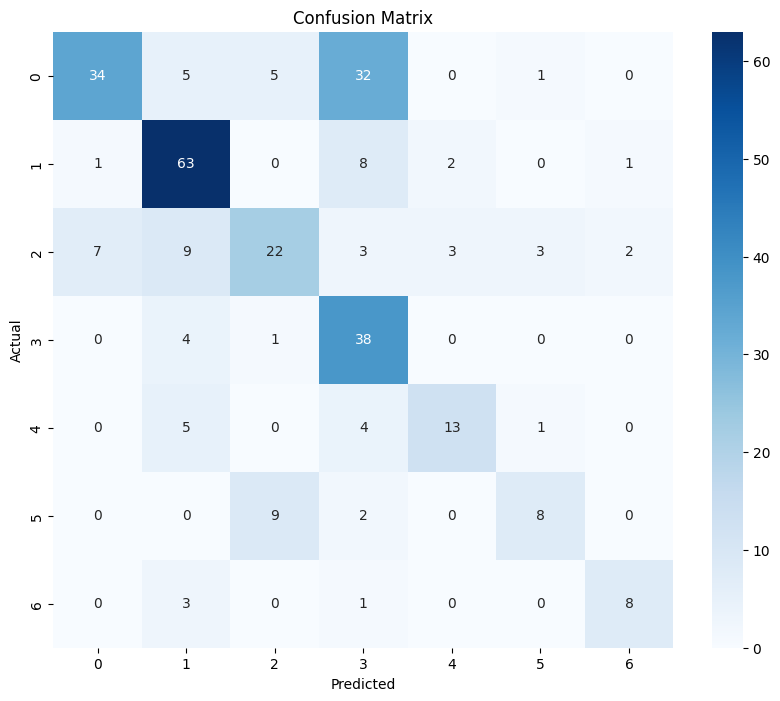

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tahminleri al (modeliniz ve data generator'ınızın class_mode'u 'categorical' ise bu şekilde çalışır)
val_pred = model.predict(val_data_generator, steps=np.ceil(val_data_generator.samples / val_data_generator.batch_size))
val_pred_classes = np.argmax(val_pred, axis=1)

# Gerçek etiketleri al
val_labels = val_data_generator.classes

# Classification report
print(classification_report(val_labels, val_pred_classes, target_names=list(val_data_generator.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(val_labels, val_pred_classes)

# Confusion matrix'i renkli olarak çizdir
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_data_generator.class_indices, yticklabels=val_data_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()